In [1]:
import pathlib
import requests

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import ensemble, linear_model, metrics, model_selection
from sklearn import pipeline, preprocessing, svm, tree, utils

# MNIST Dataset

The original [MNIST](http://yann.lecun.com/exdb/mnist/) dataset consists of 70000 28x28 black and white images in 10 classes. There are 60000 training images and 10000 test images.

In [2]:
# might be different if using Colab or Kaggle
PROJECT_ROOT_DIR = pathlib.Path(".")

DATA_DIR = PROJECT_ROOT_DIR / "data" / "mnist"
DATA_DIR.mkdir(parents=True, exist_ok=True)

RESULTS_DIR = PROJECT_ROOT_DIR / "results" / "mnist"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)


### Download and extract the data (if using Colab or Kaggle!)

In [3]:
URL = "https://github.com/KAUST-Academy/practical-tools-for-machine-learning/blob/october-2022/data/mnist/mnist.parquet?raw=true"

with open(DATA_DIR / "mnist.parquet", 'wb') as f:
    response = requests.get(URL)
    f.write(response.content)


In [6]:
%%bash

ls -lh ./data/mnist

total 21M
-rw-r--r-- 1 root root 21M Oct  7 12:03 mnist.parquet


### Load the data

We will load the data using the [Pandas](https://pandas.pydata.org/) library. Highly recommend the most recent edition of [*Python for Data Analysis*](https://learning.oreilly.com/library/view/python-for-data/9781491957653/) by Pandas creator Wes Mckinney for anyone interested in learning how to use Pandas.

In [7]:
data = pd.read_parquet(DATA_DIR / "mnist.parquet")
features = data.drop("label", axis=1)
target = data.loc[:, "label"]

In [8]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 784 entries, pixel1 to pixel784
dtypes: uint8(784)
memory usage: 52.3 MB


In [9]:
target.head()

0    5
1    0
2    4
3    1
4    9
Name: label, dtype: uint8

# Creating a Test Dataset

Before we look at the data any further, we need to create a test set, put it aside, and never look at it (until we are ready to test our trainined machine learning model!). Why? We don't want our machine learning model to memorize our dataset (this is called overfitting). Instead we want a model that will generalize well (i.e., make good predictions) for inputs that it didn't see during training. To do this we hold split our dataset into training and testing datasets. The training dataset will be used to train our machine learning model(s) and the testing dataset will be used to make a final evaluation of our machine learning model(s).


In [ ]:
model_selection.train_test_split?

In [10]:
SEED = 42
SEED_GENERATOR = np.random.RandomState(SEED)


def generate_seed():
    return SEED_GENERATOR.randint(np.iinfo("uint16").max)

In [11]:
# split the dataset into training and testing data
_seed = generate_seed()
_random_state = np.random.RandomState(_seed)

train_features, test_features, train_target, test_target = model_selection.train_test_split(
    features,
    target,
    test_size=1e-1,
    random_state=_random_state
)

In [12]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63000 entries, 24297 to 27483
Columns: 784 entries, pixel1 to pixel784
dtypes: uint8(784)
memory usage: 47.6 MB


In [13]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 64951 to 57273
Columns: 784 entries, pixel1 to pixel784
dtypes: uint8(784)
memory usage: 5.3 MB


Again, if you want to you can write out the train and test sets to disk to avoid having to recreate them later.

In [14]:
_ = (train_features.join(train_target)
                   .to_parquet(DATA_DIR / "train.parquet", index=False))

_ = (test_features.join(test_target)
                   .to_parquet(DATA_DIR / "test.parquet", index=False))

# Select, train, and validate some models

## Linear Support Vector Machines

In [15]:
svm.LinearSVC?

In [16]:
_seed = generate_seed()

_classifier_hyperparameters = {
    "dual": False,
    "tol": 0.0001,
    "C": 1.0,
    "fit_intercept": True,
    "class_weight": None,
    "verbose": 0,
    "random_state": np.random.RandomState(_seed),
    "max_iter": 1000,
}

linear_svm_pipeline = pipeline.make_pipeline(
    preprocessing.MinMaxScaler(),
    svm.LinearSVC(**_classifier_hyperparameters)
)

In [17]:
_ = linear_svm_pipeline.fit(train_features, train_target)

After training the pipeline we can assess its performance on the training data...

In [18]:
# make predictions
_train_predictions = linear_svm_pipeline.predict(train_features)

# report the accuracy on the training data
_report = metrics.classification_report(
    train_target,
    _train_predictions,
)
print(_report)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      6192
           1       0.96      0.98      0.97      7083
           2       0.92      0.91      0.92      6264
           3       0.91      0.90      0.91      6408
           4       0.93      0.94      0.93      6213
           5       0.90      0.88      0.89      5696
           6       0.95      0.96      0.96      6163
           7       0.94      0.94      0.94      6579
           8       0.89      0.87      0.88      6121
           9       0.90      0.89      0.90      6281

    accuracy                           0.93     63000
   macro avg       0.93      0.93      0.93     63000
weighted avg       0.93      0.93      0.93     63000



...and then assess its performance on new data using cross validation.

In [19]:
CV_FOLDS = 3

_cv_predictions = model_selection.cross_val_predict(
    linear_svm_pipeline,
    X=train_features,
    y=train_target,
    cv=CV_FOLDS,
    n_jobs=-1,
    verbose=1
)

# report the accuracy on the cv data
_report = metrics.classification_report(
    train_target,
    _cv_predictions,
)
print(_report)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min finished


              precision    recall  f1-score   support

           0       0.95      0.97      0.96      6192
           1       0.95      0.97      0.96      7083
           2       0.91      0.89      0.90      6264
           3       0.90      0.88      0.89      6408
           4       0.91      0.93      0.92      6213
           5       0.88      0.86      0.87      5696
           6       0.94      0.95      0.94      6163
           7       0.93      0.93      0.93      6579
           8       0.88      0.85      0.87      6121
           9       0.88      0.88      0.88      6281

    accuracy                           0.91     63000
   macro avg       0.91      0.91      0.91     63000
weighted avg       0.91      0.91      0.91     63000



You can also use SGD to fit linear support vector machines.

In [20]:
linear_model.SGDClassifier?

In [ ]:
_seed = generate_seed()

_classifier_hyperparameters = {
    "loss": "hinge",
    "fit_intercept": True,
    "verbose": 0,
    "random_state": np.random.RandomState(_seed),
}

linear_svm_pipeline = pipeline.make_pipeline(
    preprocessing.MinMaxScaler(),
    linear_model.SGDClassifier(**_classifier_hyperparameters)
)

In [ ]:
_ = linear_svm_pipeline.fit(train_features, train_target)

In [ ]:
# make predictions
_train_predictions = linear_svm_pipeline.predict(train_features)

# report the accuracy on the training data
_report = metrics.classification_report(
    train_target,
    _train_predictions,
)
print(_report)

In [ ]:
_cv_predictions = model_selection.cross_val_predict(
    linear_svm_pipeline,
    X=train_features,
    y=train_target,
    cv=CV_FOLDS,
    n_jobs=-1,
    verbose=1
)

# report the accuracy on the cv data
_report = metrics.classification_report(
    train_target,
    _cv_predictions,
)
print(_report)

### Exercise: Early Stopping

Read through the documentation for the [`linear_model.SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) and implement a linear SVM and train the model using early stopping to control overfitting.

In [ ]:
linear_model.SGDClassifier?

In [21]:
_seed = generate_seed()

_classifier_hyperparameters = {
    "loss": "hinge",
    "fit_intercept": True,
    "early_stopping": True,
    "validation_fraction": 1e-1,
    "learning_rate": "optimal",
    "n_jobs": -1,
    "verbose": 0,
    "max_iter": 10000,
    "random_state": np.random.RandomState(_seed),
}

linear_svm_pipeline = pipeline.make_pipeline(
    preprocessing.MinMaxScaler(),
    linear_model.SGDClassifier(**_classifier_hyperparameters)
)

In [22]:
_ = linear_svm_pipeline.fit(train_features, train_target)

In [23]:
# make predictions
_train_predictions = linear_svm_pipeline.predict(train_features)

# report the accuracy on the training data
_report = metrics.classification_report(
    train_target,
    _train_predictions,
)
print(_report)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      6192
           1       0.94      0.98      0.96      7083
           2       0.90      0.90      0.90      6264
           3       0.84      0.91      0.87      6408
           4       0.91      0.92      0.91      6213
           5       0.88      0.86      0.87      5696
           6       0.90      0.97      0.93      6163
           7       0.92      0.93      0.92      6579
           8       0.93      0.72      0.81      6121
           9       0.86      0.88      0.87      6281

    accuracy                           0.90     63000
   macro avg       0.90      0.90      0.90     63000
weighted avg       0.90      0.90      0.90     63000



## Decision Trees

[Decision Trees](https://scikit-learn.org/stable/modules/tree.html) are a non-parametric supervised learning method used for [classification](https://scikit-learn.org/stable/modules/tree.html#tree-classification) and [regression](https://scikit-learn.org/stable/modules/tree.html#tree-regression). The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

In [24]:
tree.DecisionTreeClassifier?

In [25]:
_seed = generate_seed()

_classifier_hyperparameters = {
    "random_state": np.random.RandomState(_seed)
}

decision_tree_pipeline = tree.DecisionTreeClassifier(**_classifier_hyperparameters)

# here we fit using the raw training features
_ = decision_tree_pipeline.fit(train_features, train_target)

In [26]:
# make predictions
_train_predictions = decision_tree_pipeline.predict(train_features)

# report the accuracy on the training data
_report = metrics.classification_report(
    train_target,
    _train_predictions,
)
print(_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6192
           1       1.00      1.00      1.00      7083
           2       1.00      1.00      1.00      6264
           3       1.00      1.00      1.00      6408
           4       1.00      1.00      1.00      6213
           5       1.00      1.00      1.00      5696
           6       1.00      1.00      1.00      6163
           7       1.00      1.00      1.00      6579
           8       1.00      1.00      1.00      6121
           9       1.00      1.00      1.00      6281

    accuracy                           1.00     63000
   macro avg       1.00      1.00      1.00     63000
weighted avg       1.00      1.00      1.00     63000



Wait, what!? No error at all? Could this model really be absolutely perfect? Unfortunately it is much more likely that the model has badly overfit the training data. How can you be sure? As we saw earlier, you don’t want to touch the testing dataset until you are ready to launch a model you are confident about, so you need to use part of the training set for training and part of it for model validation.

The following code use Scikit-Learn [`model_selection.cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) to randomly split the training set into `CV_FOLDS` distinct subsets called folds, then it trains and evaluates our model `CV_FOLDS` times, picking a different fold for evaluation every time and training on the other `CV_FOLDS-1` folds. The result is an array containing the `CV_FOLDS` evaluation scores.

In [27]:
estimator_scores = model_selection.cross_val_score(
    decision_tree_pipeline,
    X=train_features,
    y=train_target,
    cv=CV_FOLDS,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   36.4s finished


In [28]:
estimator_scores.mean()

0.863111111111111

The following code use Scikit-Learn [`model_selection.cross_val_predict`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html) to randomly split the training set into `CV_FOLDS` distinct subsets called folds, then it trains the model and makes predictions using the trained model `CV_FOLDS` times, picking a different fold to use when making prediction every time and training on the other `CV_FOLDS-1` folds. 

In [29]:
_cv_predictions = model_selection.cross_val_predict(
    decision_tree_pipeline,
    X=train_features,
    y=train_target,
    cv=CV_FOLDS,
    n_jobs=-1,
    verbose=1
)

# report the accuracy on the training data
_report = metrics.classification_report(
    train_target,
    _cv_predictions,
)
print(_report)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   34.8s finished


              precision    recall  f1-score   support

           0       0.92      0.92      0.92      6192
           1       0.94      0.95      0.94      7083
           2       0.84      0.83      0.84      6264
           3       0.83      0.82      0.83      6408
           4       0.85      0.87      0.86      6213
           5       0.80      0.81      0.81      5696
           6       0.89      0.88      0.88      6163
           7       0.90      0.90      0.90      6579
           8       0.81      0.79      0.80      6121
           9       0.84      0.84      0.84      6281

    accuracy                           0.86     63000
   macro avg       0.86      0.86      0.86     63000
weighted avg       0.86      0.86      0.86     63000



### Understanding Feature Importance

One of the nice features of decision trees is that they provide a way to measure the importance of each of feature. Understanding feature importance is a topic all unto itself. If you are interested in pulling this thread, then I recommend that you start with [SHapley Additive Explanations (SHAP)](https://shap.readthedocs.io/en/latest/index.html) and then take a look through [*Interpretable Machine Learning*](https://christophm.github.io/interpretable-ml-book/).

In [30]:
decision_tree_pipeline.feature_importances_

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.92601265e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.39275198e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [31]:
is_positive = decision_tree_pipeline.feature_importances_ > 0
is_positive.sum() / decision_tree_pipeline.feature_importances_.size

0.6352040816326531

Because our features are pixels we can reshape and plot the features to gain some insight into what might be driving feature importance.

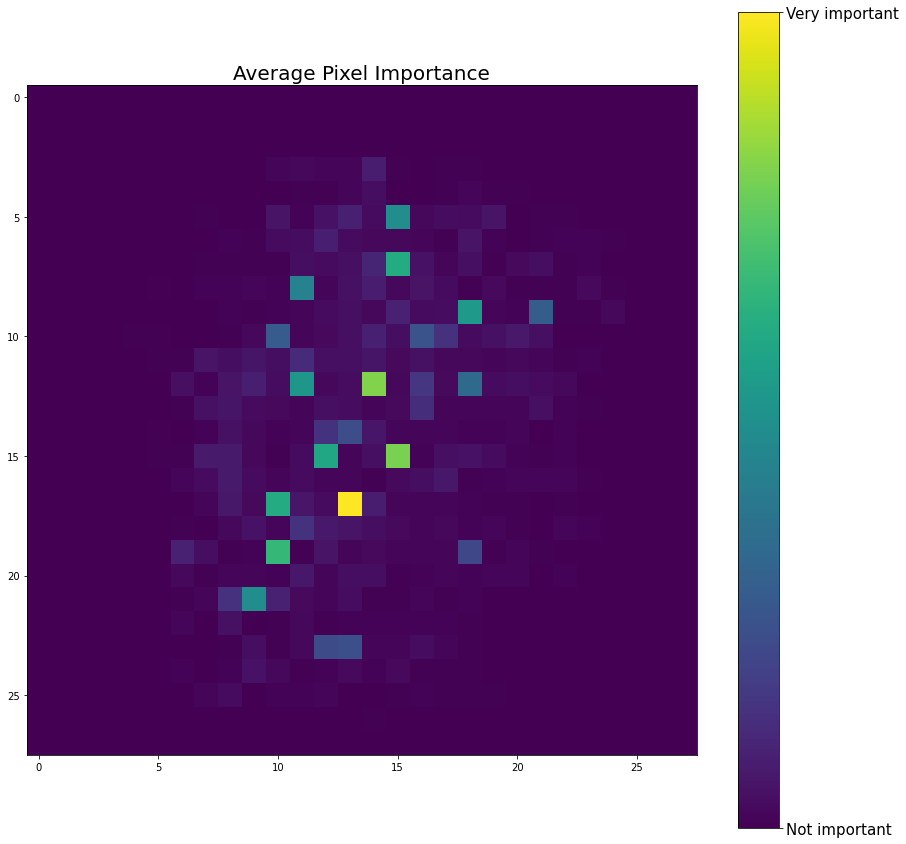

In [32]:
_, ax = plt.subplots(1, 1, figsize=(15, 15))
_average_pixel_importances = (
    decision_tree_pipeline.feature_importances_
                          .reshape((1, 28, 28))
                          .mean(axis=0)
)
plt.imshow(_average_pixel_importances)
plt.title("Average Pixel Importance", fontsize=20)

# create a colorbar
colorbar = plt.colorbar(ticks=[_average_pixel_importances.min(), _average_pixel_importances.max()])
_ = (colorbar.ax
             .set_yticklabels(["Not important", "Very important"], fontsize=15))

### Exercise: Feature Extraction

The fair number of features seem to be unimportant which suggests that perhaps we should look at ways to extract the most important features prior to fitting our decision tree model. How could we extract the most relevant features prior to fitting our model?

### Exercise: Regularizing Decision Trees

Our decision tree classifier appears to be overfitting. We need to regularize it. Decreasing `max_*` parameters and increasing `min_*` parameters will increase the amount of regularization applied to the model and will help reduce overfitting.

In [ ]:
tree.DecisionTreeClassifier?

In [ ]:
_seed = generate_seed()

_classifier_hyperparameters = {
    "criterion": "entropy",
    "max_depth": 32,
    "max_features": "sqrt",
    "min_samples_leaf": 1e-3,
    "min_samples_split": 2e-3,
    "random_state": np.random.RandomState(_seed)
}

decision_tree_pipeline = tree.DecisionTreeClassifier(**_classifier_hyperparameters)
_ = decision_tree_pipeline.fit(train_features, train_target)

# make predictions using cv
_cv_predictions = model_selection.cross_val_predict(
    decision_tree_pipeline,
    X=train_features,
    y=train_target,
    cv=CV_FOLDS,
    n_jobs=-1,
    verbose=1
)

# create a classification report
_report = metrics.classification_report(
    train_target,
    _cv_predictions,
)
print(_report)

### Exercise: Error Analysis

Compute the normalized confusion matrix for your decision tree classifier and plot it. Do you notice any patterns? What are the three classes for which your decision tree classifier peforms the worst?

In [ ]:
# insert code here!

## Ensemble Methods

Building a model on top of many other models is called [ensemble](https://scikit-learn.org/stable/modules/ensemble.html) learning and it is often a great approach to improve the predictions of your machine learning pipeline.

#### Random Forests

Let’s try the [`ensemble.RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html). Random forests work by training many decision trees on random subsets of the features, then averaging the predictions made by each of the decision trees to arrive at an overall prediction.

In [33]:
ensemble.RandomForestClassifier?

In [34]:
_seed = generate_seed()
_classifier_hyperparameters = {
    "n_jobs": -1,
    "random_state": np.random.RandomState(_seed)
}

random_forest_pipeline = ensemble.RandomForestClassifier(**_classifier_hyperparameters)
_ = random_forest_pipeline.fit(train_features, train_target)

In [35]:
# make predictions
_train_predictions = random_forest_pipeline.predict(train_features)

# generate a classification report
_report = metrics.classification_report(
    train_target,
    _train_predictions,
)
print(_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6192
           1       1.00      1.00      1.00      7083
           2       1.00      1.00      1.00      6264
           3       1.00      1.00      1.00      6408
           4       1.00      1.00      1.00      6213
           5       1.00      1.00      1.00      5696
           6       1.00      1.00      1.00      6163
           7       1.00      1.00      1.00      6579
           8       1.00      1.00      1.00      6121
           9       1.00      1.00      1.00      6281

    accuracy                           1.00     63000
   macro avg       1.00      1.00      1.00     63000
weighted avg       1.00      1.00      1.00     63000



##### Visualizing Feature Importance

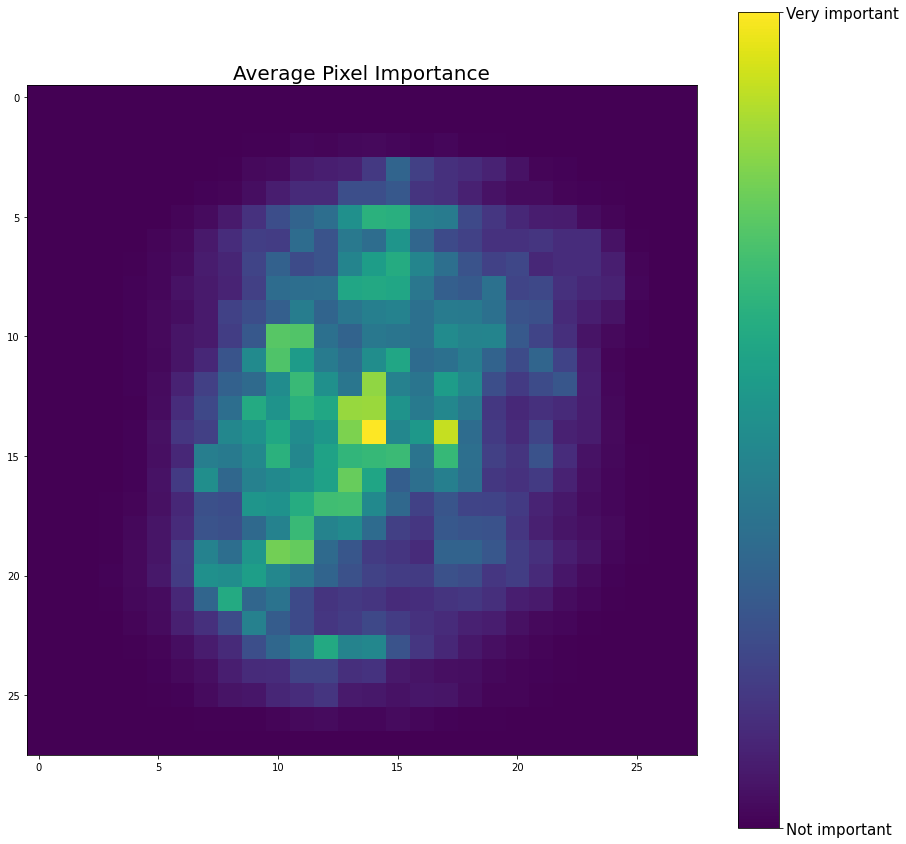

In [36]:
_, ax = plt.subplots(1, 1, figsize=(15, 15))
_average_pixel_importances = (
    random_forest_pipeline.feature_importances_
                          .reshape((1, 28, 28))
                          .mean(axis=0)
)
plt.imshow(_average_pixel_importances)
plt.title("Average Pixel Importance", fontsize=20)

# create a colorbar
colorbar = plt.colorbar(ticks=[_average_pixel_importances.min(), _average_pixel_importances.max()])
_ = (colorbar.ax
             .set_yticklabels(["Not important", "Very important"], fontsize=15))

Again you can use $k$-fold CV to estimate the validation metrics for your random forest classifier.

In [37]:
_seed = generate_seed()
_classifier_hyperparameters = {
    "n_jobs": -1,
    "random_state": np.random.RandomState(_seed)
}
random_forest_pipeline = ensemble.RandomForestClassifier(**_classifier_hyperparameters)

# make predictions using cv
_cv_predictions = model_selection.cross_val_predict(
    random_forest_pipeline,
    X=train_features,
    y=train_target,
    cv=CV_FOLDS,
    n_jobs=-1,
    verbose=1
)

# generate a classification report
_report = metrics.classification_report(
    train_target,
    _cv_predictions,
)
print(_report)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished


              precision    recall  f1-score   support

           0       0.98      0.99      0.98      6192
           1       0.98      0.98      0.98      7083
           2       0.96      0.97      0.96      6264
           3       0.96      0.95      0.96      6408
           4       0.97      0.97      0.97      6213
           5       0.96      0.96      0.96      5696
           6       0.98      0.98      0.98      6163
           7       0.97      0.96      0.97      6579
           8       0.96      0.95      0.95      6121
           9       0.95      0.95      0.95      6281

    accuracy                           0.97     63000
   macro avg       0.97      0.97      0.97     63000
weighted avg       0.97      0.97      0.97     63000



Alternatively, with random forests, you can avoid CV altogether by only using a random subset of training samples to fit each tree. The unused training samples can then be used to estimate the validation error for each tree.

In [38]:
_seed = generate_seed()
_classifier_hyperparameters = {
    "bootstrap": True,
    "max_samples": 0.9,
    "n_jobs": -1,
    "oob_score": True,
    "random_state": np.random.RandomState(_seed)
}

random_forest_pipeline = ensemble.RandomForestClassifier(**_classifier_hyperparameters)
_ = random_forest_pipeline.fit(train_features, train_target)

In [39]:
random_forest_pipeline.oob_score_

0.9656349206349206

### Exercise: Regularizing Random Forests

Our random forest classifier is pretty good. Can tune the behavior of each tree using the same tuning parameters as above. Also can control the number of estimators used in constructing the ensemble: more estimators means a more flexible model. The Scikit Learn documentation has a good discussion on [parameter tunning strategies](https://scikit-learn.org/stable/modules/ensemble.html#random-forest-parameters) for random forest classifiers and regressors. Manually tune the hyperparameters of the random forest classifier to train and find a good set of hyperparameters.

In [ ]:
_seed = generate_seed()

_classifier_hyperparameters = {
    "criterion": "entropy",
    "max_depth": 16,
    "max_features": "sqrt",
    "max_samples": 0.9,
    "min_samples_leaf": 1e-3,
    "min_samples_split": 2e-3,
    "n_estimators": 250,
    "bootstrap": True,
    "max_samples": 0.9,
    "n_jobs": -1,
    "oob_score": True,
    "random_state": np.random.RandomState(_seed)
}

random_forest_pipeline = ensemble.RandomForestClassifier(**_classifier_hyperparameters)

In [ ]:
# make predictions using cv
_cv_predictions = model_selection.cross_val_predict(
    random_forest_pipeline,
    X=train_features,
    y=train_target,
    cv=CV_FOLDS,
    n_jobs=-1,
    verbose=1
)

# generate a classification report
_report = metrics.classification_report(
    train_target,
    _cv_predictions,
)
print(_report)

### Exercise: Exploring Gradient Boosted Trees

Read the docs for to understand default behavior of the [`ensemble.HistGradientBoostingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html). Fit a gradient boosted classifier and manually tune the hyperparameters and see if you can outperform your random forest classifier.

In [40]:
ensemble.HistGradientBoostingClassifier?

In [ ]:
_seed = generate_seed()
_classifier_hyperparameters = {
    "random_state": np.random.RandomState(_seed)
}
ml_pipeline = ensemble.HistGradientBoostingClassifier(**_classifier_hyperparameters)

# make predictions using cv
_cv_predictions = model_selection.cross_val_predict(
    ml_pipeline,
    X=train_features,
    y=train_target,
    cv=CV_FOLDS,
    n_jobs=-1,
    verbose=1
)

# generate a classification report
_report = metrics.classification_report(
    train_target,
    _cv_predictions,
)
print(_report)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


### Exercise: Voting Classifiers (Challenge!)

Read the docs to understand how to create a [`ensemble.VotingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) using a `svm.LinearSVC`, a `ensemble.RandomForest`, and an `ensemble.HistGradientBoostingClassifier`. Does this classifier out perform the best individual classifier?

In [ ]:
# insert y_seed = generate_seed()

_sgd_hyperparameters = {
    "loss": "hinge",
    "n_jobs": -1,
    "random_state": np.random.RandomState(_seed)    
}

_sgd_pipeline = pipeline.make_pipeline(
    preprocessing.MinMaxScaler(),
    linear_model.SGDClassifier(**_sgd_hyperparameters),
)

_seed = generate_seed()

_random_forest_hyperparameters = {
    "n_estimators": 1000,
    "n_jobs": -1,
    "max_depth": 3,
    "random_state": np.random.RandomState(_seed)
}

_kneighbors_hyperparameters = {
    "n_neighbors": 5,
    "n_jobs": -1,
}

_ml_pipelines = [
    ("sgd_classifier", _sgd_pipeline),
    ("random_forest_classifier", ensemble.RandomForestClassifier(**_random_forest_hyperparameters)),
    ("knearest_classifier", neighbors.KNeighborsClassifier(**_kneighbors_hyperparameters)),
]

_voting_classifier_hyperparameters = {
    "voting": "hard",
    "n_jobs": -1
}

classifier = ensemble.VotingClassifier(
    _ml_pipelines,
    **_voting_classifier_hyperparameters,
)ou code here!

In [ ]:
_ = classifier.fit(train_features, train_target)

In [ ]:
_train_predictions = classifier.predict(train_features)

_report = metrics.classification_report(
    train_target,
    _train_predictions
)

print(_report)

# Evaluate your models on the test dataset

After tweaking your models for a while, you eventually have a system that performs sufficiently well. Now is the time to evaluate the final model on the test set. Remember to re-train your model on the full training data prior to evaluating on the test data.

In [ ]:
estimators = [
    linear_svm_pipeline,
    decision_tree_pipeline,
    random_forest_pipeline,
]

for estimator in estimators:
    _ = estimator.fit(train_features, train_target)

In [ ]:
for estimator in estimators:

    # make predictions
    _test_predictions = estimator.predict(test_features)

    # generate a classification report
    _report = metrics.classification_report(
        test_target,
        _test_predictions,
    )
    print(estimator.__class__)
    print(_report)


If you did a lot of tuning, the performance will usually be slightly worse than what you measured using cross-validation (because your system ends up fine-tuned to perform well on the validation data and will likely not perform as well on new, unknown datasets). It is not the case in this example, but when this happens you must resist the temptation to tweak the hyperparameters to make the numbers look good on the test set; the improvements would be unlikely to generalize to new data.